In [1]:
%reload_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import sys
code_dir = os.path.dirname(os.getcwd())
sys.path.append(code_dir)

import json
import math
from glob import glob
from itertools import permutations
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import IPython.display as ipd

tracks_csv_path = "/home/oaraz/nextcore/fingerprinting/datasets/neural-audio-fp-dataset/extras/fma_info/tracks.csv"
genres_csv_path = "/home/oaraz/nextcore/fingerprinting/datasets/neural-audio-fp-dataset/extras/fma_info/genres.csv"

## Read FMA Tracks CSV

In [ ]:
df_full = pd.read_csv(tracks_csv_path, low_memory=False)
print(df_full.shape)
df_full.head()

In [ ]:
df_full.columns

In [ ]:
df_full.iloc[0]

In [ ]:
df_full['set'].unique()

In [ ]:
print(df_full[df_full['set']=="training"].shape)
print(df_full[df_full['set']=="validation"].shape)
print(df_full[df_full['set']=="test"].shape)

In [ ]:
df_full['set.1'].unique()

In [ ]:
print(df_full[df_full['set.1']=="small"].shape)
print(df_full[df_full['set.1']=="medium"].shape)
print(df_full[df_full['set.1']=="large"].shape)

In [ ]:
total_unique = 81574 + 17000 + 8000
print(total_unique)

### Understand NAFP Dataset
all 8000 of small and 2000 from medium used for training
500 val 
500 query

total used 11000
total different 106574

In [ ]:
total_used = 10000 + 500 + 500
print(total_used)

In [ ]:
total_unique - total_used

In [ ]:
100000-93458

In [ ]:
set(df_full[df_full['set.1']=="small"].index.to_numpy()).intersection(set(df_full[df_full['set.1']=="medium"].index.to_numpy()))

## Load Again Properly With known header row

In [2]:
df = pd.read_csv(tracks_csv_path, low_memory=False, header=1)
df.rename(columns={'Unnamed: 0': 'track_id'}, inplace=True)
# To match the fodler structure
df['track_id'] = df['track_id'].apply(lambda x: x.zfill(6))
df.drop(0, axis=0, inplace=True)
print(df.shape)
df.head()

(106574, 53)


,track_id,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,...,information.1,interest,language_code,license,listens.1,lyricist,number,publisher,tags.2,title.1
1,000002,0.0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4.0,1.0,<p></p>,6073.0,NaN,...,NaN,4656.0,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293.0,NaN,3.0,NaN,[],Food
2,000003,0.0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4.0,1.0,<p></p>,6073.0,NaN,...,NaN,1470.0,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514.0,NaN,4.0,NaN,[],Electric Ave
3,000005,0.0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4.0,1.0,<p></p>,6073.0,NaN,...,NaN,1933.0,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151.0,NaN,6.0,NaN,[],This World
4,000010,0.0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4.0,6.0,NaN,47632.0,NaN,...,NaN,54881.0,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135.0,NaN,1.0,NaN,[],Freeway
5,000020,0.0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2.0,4.0,"<p> ""spiritual songs"" from Nicky Cook</p>",2710.0,NaN,...,NaN,978.0,en,Attribution-NonCommercial-NoDerivatives (aka M...,361.0,NaN,3.0,NaN,[],Spiritual Level


In [3]:
drop_cols = [
    "date_created",
    "date_released",
    "engineer",
    "favorites",
    "id",
    "producer",
    "tags",
    "active_year_begin",
    "active_year_end",
    "associated_labels",
    "comments.1",
    "date_created.1",
    "favorites.1",
    "id.1",
    "latitude",
    "location",
    "longitude",
    "related_projects",
    "tags.1",
    "website",
    "wikipedia_page",
    "comments.2",
    "date_created.2",
    "date_recorded",
    "favorites.2",
    "information.1",
    "interest",
    "language_code",
    "license",
    "listens.1",
    "lyricist",
    "number",
    "publisher",
    "tags.2",
    "listens",
]
df.drop(labels=drop_cols, axis=1, inplace=True)

In [4]:
df.columns

Index(['track_id', 'comments', 'information', 'title', 'tracks', 'type', 'bio',
       'members', 'name', 'split', 'subset', 'bit_rate', 'composer',
       'duration', 'genre_top', 'genres', 'genres_all', 'title.1'],
      dtype='object')

In [5]:
df[df['subset']=="medium"]['genre_top'].unique()

array(['Hip-Hop', 'Rock', 'Folk', 'Jazz', 'Electronic', 'Experimental',
       'Soul-RnB', 'Pop', 'Blues', 'Spoken', 'Country', 'Classical',
       'Old-Time / Historic', 'Instrumental', 'International',
       'Easy Listening'], dtype=object)

In [6]:
all_top_genres = df['genre_top'].unique().tolist()
all_top_genres.pop(2)
all_top_genres.insert(2, "None")
print(all_top_genres)

all_top_genre_counts = df['genre_top'].fillna('None').value_counts().to_dict()
all_top_genre_counts = {k: v for k,v in sorted(all_top_genre_counts.items())}

['Hip-Hop', 'Pop', 'None', 'Rock', 'Experimental', 'Folk', 'Jazz', 'Electronic', 'Spoken', 'International', 'Soul-RnB', 'Blues', 'Country', 'Classical', 'Old-Time / Historic', 'Instrumental', 'Easy Listening']


In [ ]:
print(df[(df['subset']=="large") &  (df['genre_top'].isna())].shape)

## Genre CSV

In [33]:
df_genres_full = pd.read_csv(genres_csv_path, index_col=0)
print(df_genres_full.shape)
df_genres_full

(163, 4)


,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5
...,...,...,...,...
1032,60,102,Turkish,2
1060,30,46,Tango,2
1156,26,130,Fado,2


In [34]:
len(sorted(df_genres_full['top_level'].unique()))

16

In [31]:
len(sorted(df_genres_full['parent'].unique()))

40

## Examine Your Splits

In [11]:
five_fold_dir = "/home/oaraz/nextcore/fingerprinting/datasets/5_fold-fma_full_subset/"

fold_analysis_dir = os.path.join(five_fold_dir, "fold_analysis")
os.makedirs(fold_analysis_dir, exist_ok=True)

In [11]:
all_top_genre_counts

{'Blues': 110,
 'Classical': 1230,
 'Country': 194,
 'Easy Listening': 24,
 'Electronic': 9372,
 'Experimental': 10608,
 'Folk': 2803,
 'Hip-Hop': 3552,
 'Instrumental': 2079,
 'International': 1389,
 'Jazz': 571,
 'None': 56976,
 'Old-Time / Historic': 554,
 'Pop': 2332,
 'Rock': 14182,
 'Soul-RnB': 175,
 'Spoken': 423}

In [10]:
for fold_id in range(5):

    fold_dir = os.path.join(five_fold_dir, str(fold_id))

    train_txt = os.path.join(fold_dir, "train.txt")
    test_query_txt = os.path.join(fold_dir, "test_query.txt")
    #test_dummy_txt = os.path.join(fold_dir, "test_dummy.txt")

    # Train Set
    with open(train_txt, "r") as in_f:
        train_paths = [l.strip() for l in in_f.readlines()]
    train_track_ids = [os.path.splitext(os.path.basename(path))[0] for path in train_paths]
    train_top_genres = []
    for track_id in train_track_ids:
        genre = df[df['track_id'] == track_id]['genre_top']
        if genre.isna().item():
            genre = "None"
        else:
            genre = genre.item()
        train_top_genres.append(genre)

    # Test Query
    with open(test_query_txt, "r") as in_f:
        test_query_paths = [l.strip() for l in in_f.readlines()]
    test_query_track_ids = [os.path.splitext(os.path.basename(path))[0] for path in test_query_paths]
    test_query_top_genres = []
    for track_id in test_query_track_ids:
        genre = df[df['track_id'] == track_id]['genre_top']
        if genre.isna().item():
            genre = "None"
        else:
            genre = genre.item()
        test_query_top_genres.append(genre) 

    # Convert to counter and add missing genres if there are
    train_top_genre_counter = Counter(train_top_genres)
    test_query_top_genre_counter = Counter(test_query_top_genres)
    for genre in all_top_genres:
        if genre not in train_top_genre_counter.keys():
            train_top_genre_counter[genre] = 0
        if genre not in test_query_top_genre_counter.keys():
            test_query_top_genre_counter[genre] = 0

    # Sort by genre
    train_top_genre_counter = {k: v for k,v in sorted(train_top_genre_counter.items())}
    test_query_top_genre_counter = {k: v for k,v in sorted(test_query_top_genre_counter.items())}
    
    fig,ax = plt.subplots(nrows=3, figsize=(15,12), constrained_layout=True,)

    fig.suptitle(f"Top Genre Distribution of Fold{fold_id}")

    ax[0].bar(all_top_genre_counts.keys(), all_top_genre_counts.values())
    ax[0].set_title("FMA Large")

    ax[1].bar(train_top_genre_counter.keys(), train_top_genre_counter.values())
    ax[1].set_title("Training Set")

    ax[2].bar(test_query_top_genre_counter.keys(), test_query_top_genre_counter.values())
    ax[2].set_title("Test Query Set")

    for _x in ax:
        _x.grid()
        _x.set_ylabel("#Tracks (log)")
        _x.set_xlabel("Genres")
        _x.tick_params(axis='x', labelrotation = 15)
        _x.set_yscale("log")
        _x.set_yticks(10**np.arange(6))

    fig.savefig(os.path.join(fold_analysis_dir, f"{fold_id}.png"))

    plt.close()

In [ ]:
fig,ax = plt.subplots(nrows=3, figsize=(15,12), constrained_layout=True,)

fig.suptitle(f"Top Genre Distribution of Fold{fold_id}")

ax[0].bar(all_top_genre_counts.keys(), all_top_genre_counts.values())
ax[0].set_title("FMA Large")

ax[1].bar(train_top_genre_counter.keys(), train_top_genre_counter.values())
ax[1].set_title("Training Set")

ax[2].bar(test_query_top_genre_counter.keys(), test_query_top_genre_counter.values())
ax[2].set_title("Test Query Set")

for _x in ax:
    _x.grid()
    _x.set_ylabel("#Tracks (log)")
    _x.set_xlabel("Genres")
    _x.tick_params(axis='x', labelrotation = 15)
    _x.set_yscale("log")
    _x.set_yticks(10**np.arange(6))

plt.show()

## Sample Here

In [7]:
from sklearn.model_selection import train_test_split

In [12]:
def count_genres(df):
    top_genre_counts = df['genre_top'].fillna('None').value_counts().to_dict()
    top_genre_counts = {k: v for k,v in sorted(top_genre_counts.items())}
    return top_genre_counts

In [14]:
train_val_test_df = df[df['subset']=="medium"].sample(n=16000, random_state=27)
print(train_val_test_df.shape)
train_val_test_df.head()

train_val_df, test_query_df = train_test_split(train_val_test_df, test_size=5000, random_state=27)
print(test_query_df.shape)
train_df, val_df = train_test_split(train_val_df, test_size=1000, random_state=27)
print(train_df.shape)
print(val_df.shape)

(16000, 18)
(5000, 18)
(10000, 18)
(1000, 18)


In [18]:
train_top_genre_counter = count_genres(train_df)
val_top_genre_counter = count_genres(val_df)
test_query_top_genre_counter = count_genres(test_query_df)

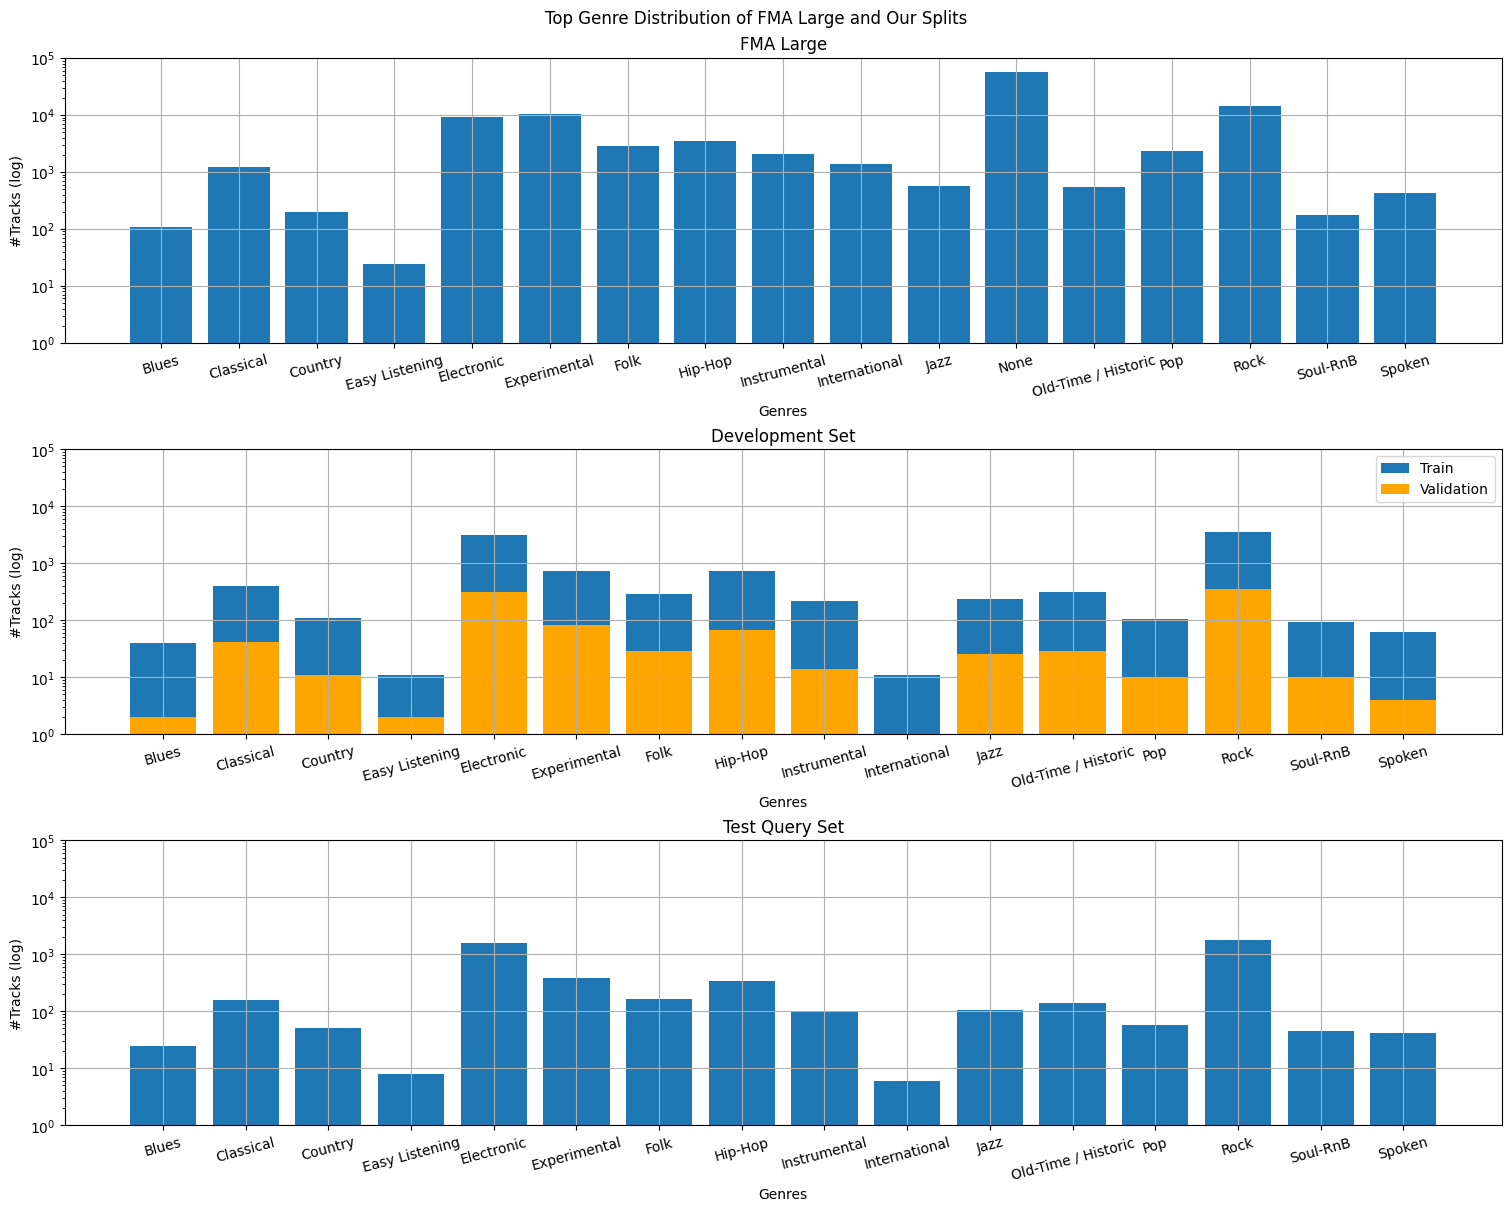

In [22]:
fig,ax = plt.subplots(nrows=3, figsize=(15,12), constrained_layout=True)

ax = np.array(ax).flatten()

fig.suptitle(f"Top Genre Distribution of FMA Large and Our Splits")

ax[0].bar(all_top_genre_counts.keys(), all_top_genre_counts.values())
ax[0].set_title("FMA Large")

ax[1].bar(train_top_genre_counter.keys(), train_top_genre_counter.values(), label="Train")
ax[1].bar(val_top_genre_counter.keys(), val_top_genre_counter.values(), color="orange", label="Validation")
ax[1].set_title("Development Set")
ax[1].legend()

ax[2].bar(test_query_top_genre_counter.keys(), test_query_top_genre_counter.values())
ax[2].set_title("Test Query Set")

for _x in ax:
    _x.grid()
    _x.set_ylabel("#Tracks (log)")
    _x.set_xlabel("Genres")
    _x.tick_params(axis='x', labelrotation=15)
    _x.set_yscale("log")
    _x.set_yticks(10**np.arange(6))

plt.show()

## Examine the NAFP Splits, Find Missing tracks

In [ ]:
import glob
import os
from itertools import combinations
import random

In [ ]:
music_dir = "/home/oaraz/nextcore/fingerprinting/datasets/neural-audio-fp-dataset/music"

train_dir = os.path.join(music_dir, "train-10k-30s")
val_dir = os.path.join(music_dir, "val-query-db-500-30s")
test_dummy_dir = os.path.join(music_dir, "test-dummy-db-100k-full/fma_full")
test_query_db_dir = os.path.join(music_dir, "test-query-db-500-30s/db")

In [ ]:
train_fps = sorted(glob.glob(os.path.join(train_dir, "**/*.wav"), recursive=True))
val_fps = sorted(glob.glob(os.path.join(val_dir, "**/*.wav"), recursive=True))
test_dummy_fps = sorted(glob.glob(os.path.join(test_dummy_dir, "**/*.wav"), recursive=True))
test_query_db_fps = sorted(glob.glob(os.path.join(test_query_db_dir, "**/*.wav"), recursive=True))

In [ ]:
train_fnames = set([os.path.basename(fp) for fp in train_fps])
print(len(train_fnames))
val_fnames = set([os.path.basename(fp) for fp in val_fps])
print(len(val_fnames))
test_dummy_fnames = set([os.path.basename(fp) for fp in test_dummy_fps])
print(len(test_dummy_fnames))
test_query_db_fnames = set([os.path.basename(fp) for fp in test_query_db_fps])
print(len(test_query_db_fnames))

In [ ]:
required = 100000 - len(test_dummy_fnames)
print(required)

In [ ]:
for a,b in combinations([('train', train_fnames), ('val', val_fnames), ('test_dummy', test_dummy_fnames), ('test_query', test_query_db_fnames)], 2):
    print(a[0], b[0], len(a[1].intersection(b[1])))

In [ ]:
train_val = train_fnames.union(val_fnames)
print(len(train_val))

missing_ids = random.sample(list(train_val), k=required)
print(len(missing_ids))
print(len(set(missing_ids).intersection(test_dummy_fnames)))

print(len(set(missing_ids).intersection(test_query_db_fnames)))

In [ ]:
with open("/home/oaraz/nextcore/fingerprinting/datasets/neural-audio-fp-dataset-missing_6542/missing_ids.txt", "w") as o_f:
    o_f.write("\n".join(missing_ids))

for fnames in [train_fnames, val_fnames, test_dummy_fnames, test_query_db_fnames]:
    for fname in fnames:
        fname = os.path.splitext(fname)[0]
        if df[df['track_id']==int(fname)].size==0:
            print("wtf")

## Move files

In [ ]:
with open("/home/oaraz/nextcore/fingerprinting/datasets/neural-audio-fp-dataset-missing_6542/missing_ids.txt", "r") as i_f:
    missing_ids = [id.strip() for id in i_f.readlines()]
for id in missing_ids:
    if id == "":
        print("wtf")

In [ ]:
missing_ids[:10]

In [ ]:
with open("/home/oaraz/nextcore/fingerprinting/datasets/neural-audio-fp-dataset-missing_6542/missing_ids-source_paths.txt", "w") as o_f:
    for id in missing_ids:
        id = os.path.splitext(id)[0]
        source_path = os.path.join(id[:3], f"{id}.mp3") # "/mnt/mtgdb-audio/incoming/fma/audio"
        o_f.write(f"{source_path}\n")

In [ ]:
source_path

## test_ids

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
test_ids_path = "/home/oaraz/nextcore/fingerprinting/neural-audio-fp/eval/test_ids_icassp2021.npy"
test_ids = np.load(test_ids_path)

In [ ]:
boundaries_path = "/home/oaraz/nextcore/fingerprinting/neural-audio-fp/logs/emb/640_lamb/101/db-track_boundaries.npy"
boundaries = np.load(boundaries_path)

In [ ]:
counter = {n: 0 for n in range(500)}
for test_id in test_ids:
    track_idx = np.where((boundaries[:,0]<=test_id) & (boundaries[:,1]>=test_id))[0][0]
    counter[track_idx] += 1

In [ ]:
sum([1 if c==0 else 0 for c in counter.values()])

In [ ]:
np.median(list(counter.values()))

In [ ]:
max(counter.values())

In [ ]:
x = list(counter.keys())
y = list(counter.values())
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(x, y)
ax.grid()
plt.show()

In [ ]:
test_seq_len = [1, 3, 5, 9, 15, 19]

test_ids = []
for s,e in boundaries:
    # Cut the query into segments of test_seq_len
    # If the last segment is shorter than test_seq_len, ignore it
    test_ids.append(np.arange(s, e+1-test_seq_len[-1], 11)) # end is inclusive
test_ids = np.concatenate(test_ids)
print(len(test_ids))

counter = {n: 0 for n in range(500)}
for test_id in test_ids:
    track_idx = np.where((boundaries[:,0]<=test_id) & (boundaries[:,1]>=test_id))[0][0]
    counter[track_idx] += 1
print(sum([1 if c==0 else 0 for c in counter.values()]))

x = list(counter.keys())
y = list(counter.values())
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(x, y)
ax.grid()
plt.show()

In [ ]:
test_seq_len = [1, 3, 5, 9, 15, 19]

test_ids = []
for s,e in boundaries:
    # Cut the query into segments of test_seq_len
    # If the last segment is shorter than test_seq_len, ignore it
    test_ids.append(np.arange(s, e+1-test_seq_len[-1], 5)) # end is inclusive
test_ids = np.concatenate(test_ids)

print(len(test_ids))

counter = {n: 0 for n in range(500)}
for test_id in test_ids:
    track_idx = np.where((boundaries[:,0]<=test_id) & (boundaries[:,1]>=test_id))[0][0]
    counter[track_idx] += 1

x = list(counter.keys())
y = list(counter.values())
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(x, y)
ax.grid()
plt.show()

### Check if boundaries are preserved

In [ ]:
test_ids_path = "/home/oaraz/nextcore/fingerprinting/neural-audio-fp/eval/test_ids_icassp2021.npy"
test_ids = np.load(test_ids_path)

boundaries_path = "/home/oaraz/nextcore/fingerprinting/neural-audio-fp/logs/emb/640_lamb/101/db-track_boundaries.npy"
boundaries = np.load(boundaries_path)

In [ ]:
test_seq_len = [1, 3, 5, 9, 15, 19]

In [ ]:
counter = 0
for test_id in test_ids:
    track_idx = np.where((boundaries[:,0]<=test_id) & (boundaries[:,1]>=test_id))[0][0]
    _, u_b = boundaries[track_idx]
    for s_l in test_seq_len:
        if test_id + s_l - 1 <= u_b:
            continue
        else:
            #print(test_id, s_l, u_b)
            counter += 1
print(100*counter/(len(test_seq_len)*len(test_ids)))